In [1]:
import os
import pandas as pd
import seaborn as sns
import h5py as h5
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from utils.metrics import GTSortingComparison
from model.Lca import LCA1iter, NSS_online
import spikeinterface.full as si
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from utils.build_dataset import init_dataloader

batch_size = 16
fs = 10000
nchan = 4


def save_results(
    file_path, dst_name, model_name, N, trial, nspikes, spike_processed, snr, fscore_nss
):
    if os.path.exists(file_path):
        previous_perf = pd.read_pickle(file_path)
    else:
        previous_perf = pd.DataFrame(
            columns=[
                "model",
                "dataset_name",
                "N",
                "nspikes",
                "trial",
                "spike_processed",
                "snr",
                "fscore",
            ]
        )
    # first create pd Dataframe with time_step, snr, fscore
    perf = pd.DataFrame(columns=["spike_processed", "snr", "fscore"])
    for ni in range(snr.size):
        perf = pd.concat(
            [
                perf,
                pd.DataFrame(
                    {
                        "spike_processed": spike_processed,
                        "snr": np.repeat(snr[ni], spike_processed.size),
                        "fscore": fscore_nss[ni],
                    }
                ),
            ],
            axis=0,
        )
    perf.insert(0, "model", model_name)
    perf.insert(1, "dataset_name", dst_name)
    perf.insert(2, "N", N)
    perf.insert(3, "nspikes", nspikes)
    perf.insert(4, "trial", trial)
    res_df = pd.concat([previous_perf, perf], axis=0)
    res_df.to_pickle(file_path)


def load_dataset(ds, tmax=180):
    data_file = ds
    with h5.File(data_file, "r") as f:
        wvs = np.array(f["wvs"][:], dtype=np.float32)
        gt_raster = np.array(f["gt_raster"][:], dtype=np.int32)
        peaks_idx = np.array(f["peaks_idx"][:], dtype=np.int32)
        try:
            snr = np.array(f["snr"][:], dtype=np.float32)
        except:
            snr = np.array(f["snr"], dtype=np.float32)
    f.close()
    # normalize waveforms with l2-norm
    l2_norm = np.linalg.norm(wvs, ord=2, axis=1)
    if np.sum(l2_norm < 1e-6) > 0:
        print("Warning: some waveforms are null")
    wvs = wvs / np.linalg.norm(wvs, ord=2, axis=1)[:, None]
    # filter and keep only wvs which peaks_idx are below tmax
    mask_detected = peaks_idx < tmax * fs
    mask_gt = gt_raster[0] < tmax * fs
    wvs, peaks_idx = wvs[mask_detected], peaks_idx[mask_detected]
    gt_raster = gt_raster[:, mask_gt]
    dataset = {"wvs": wvs, "gt_raster": gt_raster, "raster": peaks_idx, "snr": snr}
    dataloader = init_dataloader(wvs, peaks_idx, batch_size, normalize=False)
    return dataset, dataloader


def run_nss(dataloader, seed, N=2, model="TDQ", ths=[0.04, 0.04], n_atoms=[120, 10]):
    params_nss = {
        "n_atoms1": n_atoms[0],
        "n_atoms2": n_atoms[1],
        "D1_positive": False,
        "D2_positive": True,
        "th1": ths[0],
        "th2": ths[1],
        "fs": fs,
        "tau": 2e-3,
        "iters": 200,
        "lr": 0.07,
        "n_model": model,
        "q": 2**N - 1,
        "seed": seed,
    }
    params_nss["gamma"] = 1 / params_nss["fs"] / params_nss["tau"]

    ## init lca1
    lca1 = LCA1iter(
        input_size=next(iter(dataloader))[0].shape[1],
        gamma=params_nss["gamma"],
        threshold=params_nss["th1"],
        n_atoms=params_nss["n_atoms1"],
        lr=params_nss["lr"],
        neuron_model=params_nss["n_model"],
        q=params_nss["q"],
        D_positive=params_nss["D1_positive"],
        seed=params_nss["seed"],
    )
    lca2 = LCA1iter(
        input_size=params_nss["n_atoms1"],
        gamma=params_nss["gamma"],
        threshold=params_nss["th2"],
        n_atoms=params_nss["n_atoms2"],
        lr=params_nss["lr"],
        neuron_model=params_nss["n_model"],
        q=params_nss["q"],
        D_positive=params_nss["D2_positive"],
        seed=params_nss["seed"],
    )
    nss = NSS_online(lca1, lca2, params_nss["iters"], scale_factor=0.5)  # best is 0.5

    # training NSS
    nss_out = []
    n_spikes = []
    for _, (bi, ri) in enumerate(tqdm(dataloader)):
        if int(ri[-1]) / fs > 60:  # reduce lr after 60s
            nss.lca1.lr, nss.lca2.lr = 0.01, 0.01
            nss.iters = 32
            n_spikes.append(nss.lca1.n_spikes + nss.lca2.n_spikes)
        nss(bi)
        nss_out.append(nss.lca2.decoded_out.numpy())

    nss_out = np.concatenate(nss_out, axis=0)
    n_spikes = np.concatenate(n_spikes, axis=0)
    labels = np.argmax(nss_out, axis=1).astype(int)

    return labels, n_spikes


def run_pca(ds, seed, n_pcs=3, n_clusters=4, nchan=4, tend=60):
    np.random.seed(seed)
    dataset, _ = load_dataset(ds)
    pcs = np.zeros((dataset["wvs"].shape[0], nchan, n_pcs))
    for chi in range(nchan):
        # create a mask to keep only the wvs with peak_idx < 120s
        mask = dataset["raster"] < tend * fs
        wvs_train = dataset["wvs"][mask]
        wvs_eval = dataset["wvs"][~mask]
        wvs_train = wvs_train.reshape(wvs_train.shape[0], nchan, -1)
        wvs_eval = wvs_eval.reshape(wvs_eval.shape[0], nchan, -1)
        pca = PCA(n_components=n_pcs, random_state=seed, svd_solver="arpack")
        pcs[mask, chi] = pca.fit_transform(wvs_train[:, chi, :])
        pcs[~mask, chi] = pca.transform(wvs_eval[:, chi, :])

    pcs = pcs.reshape(-1, nchan * n_pcs)
    kmeans = KMeans(
        n_clusters=n_clusters, random_state=seed, init="random", n_init=1
    ).fit(pcs)
    labels = kmeans.labels_
    return labels

### F1-score when N varies

In [ ]:
# parameters
seed = 0
nneurons = 5

# # compute for each time_step
# time_step = 30
# t0, tend = 0, 240
# trange = (t0, tend)
# time_step = np.arange(trange[0], trange[1] + 1, time_step) * fs

# compute fscore every packet of Ns spikes processed
spike_packet = 100

datasets = [49, 62, 71, 209]
# datasets = [
#     "data/hc1/hc1_d533101_dth5_tmax240_noburst.h5",
#     "data/hc1/hc1_d561104_dth5_tmax200.h5",
#     "data/hc1/hc1_d561105_dth4_tmax240.h5",
#     "data/hc1/hc1_d561106_dth4_tmax240.h5",
# ]
tmax_values = [240]  # [240, 200, 240, 240]
ds_labels = ["d533101"]  # , "d561104", "d561105", "d561106"]
N_values = [1, 2, 3, 4, 6, 8, 16, 32]
ntrials = 10
nmodel = "TDQ"

In [ ]:
## run NSS stats on simulated tetrode data for different N values
for t in range(ntrials):
    print(f"##### Running trial {t} #####")
    seed = t
    for d, ds in enumerate(datasets):
        print(f"--- Running NSS on dataset {ds} ---")
        data = f"data/tetrode/tetrode{ds}_n5_static.h5"
        dataset, dataloader = load_dataset(data, tmax=180)
        # dataset, dataloader = load_dataset(ds, tmax=tmax_values[d])
        peaks = dataset["raster"]
        gtr = dataset["gt_raster"]

        for k, N in enumerate(N_values):
            print(f"*** N={N} ***")
            labels, nsp = run_nss(
                dataloader, seed, N, model=nmodel, ths=[0.04, 0.04], n_atoms=[120, 10]
            )
            print(f"median nsp = {np.mean(nsp):.1f} +/- {np.std(nsp):.1f}")

            # compute fscore every packet of Ns spikes processed
            spike_processed, fscore_nss = [], []
            for i in range(0, len(peaks), spike_packet):
                if i + spike_packet >= len(peaks):
                    break
                mask_pred = (peaks >= peaks[i]) & (peaks < peaks[i + spike_packet])
                mask_gtr = (gtr[0] >= peaks[i]) & (gtr[0] < peaks[i + spike_packet])
                gtsort_comp = GTSortingComparison(
                    labels[mask_pred],
                    peaks[mask_pred],
                    gtr[:, mask_gtr],
                    fs,
                    delta_time=1,
                )
                score = gtsort_comp.get_fscore()
                if not score.size > 0:
                    continue
                else:
                    spike_processed.append(i)
                    fscore_nss.append(score)
            fscore_nss = np.array(fscore_nss).reshape(nneurons, -1)
            spike_processed = np.array(spike_processed)
            print(
                f" N= {N} | mean nsp = {np.mean(nsp):.1f} | mean fscore = {np.mean(fscore_nss):.2f}"
            )
            save_results(
                "logs/figure4_variation_N/tetrode_n5_spike_counts.pkl",
                f"tetrode{ds}",  # ds_labels[d],
                nmodel,  # neuron model
                N,  # TDQ precision
                t,  # trial number
                np.mean(nsp),  # number of spikes
                # time_step,
                spike_processed,
                dataset["snr"].reshape(nneurons),
                fscore_nss,
            )

In [ ]:
# datasets = [49, 62, 71, 96]
# N = 0
# nmodel = "LIF"

# for _, ds in enumerate(datasets):
#     print(f"Running NSS on dataset {ds}")
#     data = f"data/tetrode/tetrode{ds}_n5_static.h5"
#     dataset, dataloader = load_dataset(data, tmax=240)
#     peaks = dataset["raster"]
#     gtr = dataset["gt_raster"]
#     labels, nsp = run_nss(
#         dataloader, seed, N, model=nmodel, ths=[1.4, 1.4], n_atoms=[120, 10]
#     )
#     print(f"median nsp = {np.mean(nsp):.1f} +/- {np.std(nsp):.1f}")
#     # compute evolution of f-score over time
#     fscore_nss = np.zeros((nneurons, time_step.size - 1))
#     for i in range(1, time_step.size):
#         mask = (peaks >= time_step[i - 1]) & (peaks < time_step[i])
#         if np.sum(mask) == 0:
#             continue
#         else:
#             peaksi = peaks[mask]
#             gtri = gtr[:, (gtr[0] >= time_step[i - 1]) & (gtr[0] < time_step[i])]
#             gtsort_comp = GTSortingComparison(
#                 labels[mask], peaksi, gtri, fs, delta_time=2
#             )
#             fscore_nss[:, i - 1] = gtsort_comp.get_fscore()

#         # save_results(
#         #     f"logs/figure4/tetrode_n5_nss_variation_N.pkl",
#         #     f"tetrode{ds}",
#         #     nmodel,  # neuron model
#         #     N,  # TDQ precision
#         #     0,  # trial number
#         #     time_step,
#         #     dataset["snr"],
#         #     fscore_nss,
#         # )

#     print(
#         f"F1s NSS-LIF: {np.mean(fscore_nss[:, (time_step[1:] >= (120 * fs))])*100:.2f}%"
#     )

## Simulated Tetrode 
#### Plot lineplot of the impact of N on the mean fscore

In [29]:
res_file = "logs/figure4_variation_N/tetrode_n5_variation_N_nss.pkl"
res = pd.read_pickle(res_file)
res = res[~res["dataset_name"].isin(["tetrode209", "tetrode62"])]

res_file = "logs/figure4_variation_N/tetrode209_n5_variation_N_nss.pkl"
res209 = pd.read_pickle(res_file)

res_file = "logs/figure4_variation_N/tetrode62_n5_variation_N_nss.pkl"
res62 = pd.read_pickle(res_file)

# remove from res all row for dataset_name = tetrode209 and replace by res209
res_ts = res[
    (res["dataset_name"] != "tetrode209") & (res["dataset_name"] != "tetrode62")
]
res_ts = pd.concat([res, res209, res62], axis=0)
res_ts = res_ts[res_ts["spike_processed"] >= 3000]
fscore_ts = (
    res_ts.groupby(["dataset_name", "trial", "N"]).agg({"fscore": "mean"}).reset_index()
)
#
# parameters
nneurons = 5
ntrials = 20
N_values = np.sort(fscore_ts["N"].unique())
datasets_ts = fscore_ts["dataset_name"].unique()

# Load TR data
res_tr = pd.read_pickle("logs/figure4_variation_N/hc1_variation_N_nss.pkl")
res2 = res_tr[res_tr["spike_processed"] >= 0]
fscore_tr = (
    res2.groupby(["dataset_name", "trial", "N"]).agg({"fscore": "mean"}).reset_index()
)

datasets_tr = fscore_tr["dataset_name"].unique()
dst_labels = [
    ["$TS_{1}$", "$TS_{2}$", "$TS_{3}$", "$TS_{4}$"],
    ["$TR_{1}$", "$TR_{2}$", "$TR_{3}$", "$TR_{4}$"],
]

In [ ]:
# ## Supplementary material - detailed F1-score per SNR
# res = res[res["spike_processed"] >= 2000]
# fscore = (
#     res.groupby(["model", "trial", "dataset_name", "N", "snr"])
#     .agg({"fscore": "mean"})
#     .reset_index()
# )

# # parameters
# N_max = 32
# nneurons = 5
# ntrials = 20
# N_values = np.sort(fscore["N"].unique())
# N_values = N_values[N_values <= N_max]

# datasets = fscore["dataset_name"].unique()
# fig, axs = plt.subplots(2, 2, figsize=(5, 4), dpi=150, sharex=True)
# axs = axs.flatten()
# dst_labels = ["$TS_{1}$", "$TS_{2}$", "$TS_{3}$", "$TS_{4}$"]

# # construct colormap
# from matplotlib.colors import LinearSegmentedColormap

# colors = sns.color_palette("colorblind6", 4)
# # Generate colormaps for each color using Seaborn colors
# cmaps = []
# for color in colors:
#     cmap = LinearSegmentedColormap.from_list(
#         "custom_gradient", ["black", color], N=nneurons
#     )
#     cmaps.append(cmap)
# subzero_trial = 0
# for i, dst in enumerate(datasets):
#     fscore_dst_gain = pd.DataFrame(
#         columns=["model", "dataset_name", "trial", "N", "snr", "fscore_gain"]
#     )
#     fscore_dst = fscore[fscore["dataset_name"] == dst]
#     for k, si in enumerate(fscore_dst["snr"].unique()):
#         fscore_dst_snr = fscore_dst[fscore_dst["snr"] == si]
#         for j, t in enumerate(fscore_dst_snr["trial"].unique()):
#             fscore_dst_t = fscore_dst_snr[
#                 (fscore_dst_snr["trial"] == t) & (fscore_dst_snr["N"] <= N_max)
#             ]
#             fscore_dst_t = fscore_dst_t.sort_values("N")
#             # compute gain of fscore relative to N=1
#             fscore_dst_t["fscore_gain"] = (
#                 fscore_dst_t["fscore"] - fscore_dst_t["fscore"].values[0]
#             )
#             # print(f"fscore gain: {fscore_dst_t['fscore_gain'].values[:]}")
#             if (
#                 fscore_dst_t["fscore_gain"].values[1] < -0.15
#                 or fscore_dst_t["fscore_gain"].values[2] < -0.15
#             ):
#                 subzero_trial += 1
#                 continue
#             else:
#                 fscore_dst_gain = pd.concat([fscore_dst_gain, fscore_dst_t], axis=0)

#         # for k, si in enumerate(fscore_dst_gain["snr"].unique()):
#         fscore_dst_snr = fscore_dst_gain[fscore_dst_gain["snr"] == si]
#         fscore_dst_snr = fscore_dst_snr.sort_values("N")
#         fscore_dst_snr = (
#             fscore_dst_snr.groupby("N")
#             .agg({"fscore_gain": ["mean", "std"]})
#             .reset_index()
#         )
#         axs[i].plot(
#             fscore_dst_snr["N"],
#             fscore_dst_snr["fscore_gain"]["mean"],
#             label=si,
#             color=cmaps[i](k),
#         )
#         axs[i].fill_between(
#             fscore_dst_snr["N"],
#             fscore_dst_snr["fscore_gain"]["mean"]
#             - 1.96 * fscore_dst_snr["fscore_gain"]["std"] / np.sqrt(ntrials),
#             fscore_dst_snr["fscore_gain"]["mean"]
#             + 1.96 * fscore_dst_snr["fscore_gain"]["std"] / np.sqrt(ntrials),
#             color=cmaps[i](k),
#             alpha=0.1,
#         )
#     axs[i].set_ylim(-0.05, 0.25)
#     ylabels = [f"+{yi:.1f}" for yi in axs[i].get_yticks()]
#     axs[i].set_yticklabels(ylabels, fontsize=8.5)

#     axs[i].set_xscale("log", base=2)
#     axs[i].set_xticks(N_values)
#     axs[i].set_xticklabels(N_values, fontsize=8.5)
#     axs[i].text(
#         0.04,
#         1.05,
#         dst_labels[i],
#         transform=axs[i].transAxes,
#         fontsize=12,
#         verticalalignment="top",
#     )
#     snr_labels = [f"{si:.1f}" for si in fscore_dst["snr"].unique()]
#     handles, _ = axs[i].get_legend_handles_labels()
#     # plt.rcParams['legend.handlelength']=0.2
#     axs[i].legend(
#         handles,
#         snr_labels,
#         ncol=1,
#         # loc="upper right",
#         fontsize=8.5,
#         title="SNR",
#         bbox_to_anchor=(0.95, 1),
#         handlelength=0.9,
#     )
#     axs[i].spines[["top", "right"]].set_visible(False)
#     # axs[i].set_ylim(0.9, 2.1)
#     if i == 0 or i == 2:
#         axs[i].set_ylabel("$F_{1}$-score gain")
#     else:
#         axs[i].set_ylabel("")
#     if i == 2 or i == 3:
#         axs[i].set_xlabel("N-bit quantization ($log_{2}$)")

# # save figure with tight layout
# # fig.savefig("figures/fig4a_nss_fscore_ratio_N_variation.svg")
# plt.tight_layout()
# plt.show()

In [ ]:
## Variation of F1-score gain with N for TS datasets
fig, ax = plt.subplots(1, 2, figsize=(6.5, 2.5), dpi=150)
subzero_trial = 0
for k in range(2):
    cmap = sns.color_palette("colorblind", 8)[k * 4 : (k + 1) * 4]
    fscore = fscore_ts if k == 0 else fscore_tr
    datasets = datasets_ts if k == 0 else datasets_tr
    for i, dst in enumerate(datasets):
        fscore_dst_gain = pd.DataFrame(
            columns=["dataset_name", "trial", "N", "fscore_gain"]
        )
        fscore_dst = fscore[fscore["dataset_name"] == dst]
        for j, t in enumerate(fscore_dst["trial"].unique()):
            fscore_dst_t = fscore_dst[fscore_dst["trial"] == t]
            fscore_dst_t = fscore_dst_t.sort_values("N")

            # compute gain of fscore relative to N=1
            fscore_dst_t["fscore_gain"] = (
                fscore_dst_t["fscore"] - fscore_dst_t["fscore"].values[0]
            )
            if (
                fscore_dst_t["fscore_gain"].values[1] < -0.15
                or fscore_dst_t["fscore_gain"].values[2] < -0.15
            ):
                subzero_trial += 1
                continue
            else:
                fscore_dst_gain = pd.concat([fscore_dst_gain, fscore_dst_t], axis=0)
        # print(f"subzero trials: {subzero_trial}")
        fscore_dst_gain = (
            fscore_dst_gain.groupby("N")
            .agg({"fscore_gain": ["mean", "std"]})
            .reset_index()
        )
        ax[k].plot(
            fscore_dst_gain["N"],
            fscore_dst_gain["fscore_gain"]["mean"] * 100,
            label=dst_labels[k][i],
            color=cmap[i],
        )
        ax[k].fill_between(
            fscore_dst_gain["N"],
            (
                fscore_dst_gain["fscore_gain"]["mean"]
                - 1.96 * fscore_dst_gain["fscore_gain"]["std"] / np.sqrt(ntrials)
            )
            * 100,
            (
                fscore_dst_gain["fscore_gain"]["mean"]
                + 1.96 * fscore_dst_gain["fscore_gain"]["std"] / np.sqrt(ntrials)
            )
            * 100,
            color=cmap[i],
            alpha=0.1,
        )

        if i == 3:
            yticks = ax[k].get_yticks()[1:]
            steps = [2, 4] if k == 0 else [2.5, 5]
            ax[k].set_yticks(np.arange(yticks[0], yticks[-1] + 1, steps[0]), minor=True)
            ax[k].set_yticks(np.arange(yticks[0], yticks[-1] + 1, steps[1]))
            yticks = np.arange(yticks[0], yticks[-1] + 1, steps[1])
            ylabels = [f"+{yi:.0f}" if yi > 0 else f"{yi:.0f}" for yi in yticks]
            ax[k].set_yticklabels(ylabels, fontsize=11)

        ax[k].set_xscale("log", base=2)
        ax[k].set_xticks(N_values)
        ax[k].set_xticklabels(N_values, fontsize=11)
        ax[k].legend(
            ncol=4, fontsize=11, edgecolor="w", handlelength=0.8, mode="expand"
        )
        ax[k].spines[["top", "right"]].set_visible(False)
        ax[k].set_ylabel("$F_{1}$-score gain (%)", fontsize=12)
    # add a cross marker at [1,0] and a text below "TDQ1-$F_{1\infty}$"
    ax[k].scatter([1], [0], s=30, marker="x", c="k")
    posy = -0.8 if k == 0 else -1.8
    ax[k].text(1.3, posy, "NSS-1bit-$F_{1\infty}$", fontsize=11)
    ax[k].set_xlabel("N-bit quantization ($log_{2}$)", fontsize=12)
# save figure with tight layout

plt.tight_layout()
plt.show()
fig.savefig(
    "figures/fig4b_f1gain_variationN.svg", format="svg", dpi=150, bbox_inches="tight"
)

In [ ]:
# ## Supplementary Material - details on SNR
# res_tr = pd.read_pickle("logs/figure4_variation_N/hc1_variation_N_nss.pkl")
# res2 = res_tr[
#     (res_tr["spike_processed"] >= 1500)  # & (res_tr["spike_processed"] <= 1400)
# ]  #
# # res2 = res[res["time_step"] >= 120 * fs]
# fscore = (
#     res2.groupby(["model", "trial", "dataset_name", "N", "snr"])
#     .agg({"fscore": "mean"})
#     .reset_index()
# )

# # parameters
# N_max = 32
# nneurons = 1
# ntrials = 20
# N_values = np.sort(fscore["N"].unique())
# N_values = N_values[N_values <= N_max]
# cmap = sns.color_palette("colorblind", 8)[4:]
# fscore["snr"] = np.round(fscore["snr"], 1)
# fscore["dataset_name"] = fscore["dataset_name"].replace(
#     {
#         "d533101": "$TR_{1}$",
#         "d561104": "$TR_{2}$",
#         "d561105": "$TR_{3}$",
#         "d561106": "$TR_{4}$",
#     }
# )
# datasets = fscore["dataset_name"].unique()

# fig, ax = plt.subplots(figsize=(3, 2.5), dpi=150)
# for i, dst in enumerate(datasets):
#     fscore_dst_gain = pd.DataFrame(
#         columns=["model", "dataset_name", "trial", "N", "snr", "fscore_gain"]
#     )
#     fscore_dst = fscore[fscore["dataset_name"] == dst]
#     for j, t in enumerate(fscore_dst["trial"].unique()):
#         fscore_dst_t = fscore_dst[fscore_dst["trial"] == t]
#         fscore_dst_t = fscore_dst_t.sort_values("N")
#         # compute gain of fscore relative to N=1
#         fscore_dst_t["fscore_gain"] = (
#             fscore_dst_t["fscore"] - fscore_dst_t["fscore"].values[0]
#         )
#         fscore_dst_gain = pd.concat([fscore_dst_gain, fscore_dst_t], axis=0)

#     # plot fscore ratio
#     si = fscore_dst_gain["snr"].unique()[0]
#     fscore_dst_gain = fscore_dst_gain.sort_values("N")
#     fscore_dst_gain = (
#         fscore_dst_gain.groupby("N").agg({"fscore_gain": ["mean", "std"]}).reset_index()
#     )
#     ax.plot(
#         fscore_dst_gain["N"],
#         fscore_dst_gain["fscore_gain"]["mean"],
#         label=f"{si}" + f" ({dst})",
#         color=cmap[i],
#     )
#     ax.fill_between(
#         fscore_dst_gain["N"],
#         fscore_dst_gain["fscore_gain"]["mean"]
#         - 1.96 * fscore_dst_gain["fscore_gain"]["std"] / np.sqrt(ntrials),
#         fscore_dst_gain["fscore_gain"]["mean"]
#         + 1.96 * fscore_dst_gain["fscore_gain"]["std"] / np.sqrt(ntrials),
#         color=cmap[i],
#         alpha=0.1,
#     )
# ax.set_xscale("log", base=2)
# ax.set_xticks(N_values)
# ax.set_xticklabels(N_values)
# ax.spines[["top", "right"]].set_visible(False)
# ax.set_ylim(-0.02, 0.45)
# ylabels = [f"+{yi:.1f}" for yi in ax.get_yticks()]
# ax.set_yticklabels(ylabels)
# ax.legend(
#     loc="upper left",
#     ncol=2,
#     fontsize=8,
#     # bbox_to_anchor=(0.55, 1.2),
#     handlelength=0.7,
#     title="SNR",
# )
# ax.set_ylabel("$F_{1}$-score gain")
# ax.set_xlabel("N-bit quantization ($log_{2}$)")
# # save figure
# # fig.savefig("figures/fig4b_hc1_nss_fscore_ratio_N_variation.svg", bbox_inches="tight")
# plt.tight_layout()
# plt.show()

### Plot variation of nspikes with N

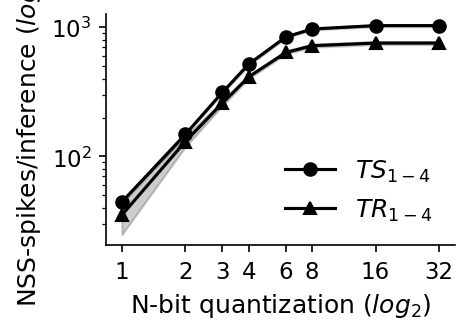

In [13]:
# load simulated tetrode results
res_ts_file = "logs/figure4_variation_N/tetrode_n5_spike_counts.pkl"
res_ts = pd.read_pickle(res_ts_file)
res_ts_f = res_ts[res_ts["spike_processed"] >= 2000]

# load hc-1 results
res_tr_file = "logs/figure4_variation_N/hc1_variation_N_nss.pkl"
res_tr = pd.read_pickle(res_tr_file)
res_tr_f = res_tr[res_tr["spike_processed"] >= 2000]

N_values = [1, 2, 3, 4, 6, 8, 16, 32]
nspikes = (
    res_ts_f.groupby(["model", "trial", "dataset_name", "N"])
    .agg({"nspikes": "mean"})
    .reset_index()
)
nspikes = pd.concat(
    [
        nspikes,
        res_tr_f.groupby(["model", "trial", "dataset_name", "N"])
        .agg({"nspikes": "mean"})
        .reset_index(),
    ],
    axis=0,
)

nspikes["dataset_name"] = nspikes["dataset_name"].replace(
    {
        "tetrode209": "TS1",
        "tetrode49": "TS2",
        "tetrode62": "TS3",
        "tetrode71": "TS4",
        "d533101": "TR1",
        "d561104": "TR2",
        "d561105": "TR3",
        "d561106": "TR4",
    }
)
ntrials = 20
fig, ax = plt.subplots(figsize=(3, 2), dpi=150)
for k in range(2):
    dst = "TS" if k == 0 else "TR"
    # for i, dst in enumerate(datasets):
    nspikes_dst = nspikes[nspikes["dataset_name"].str.contains(dst)]
    nspikes_dst = nspikes_dst.sort_values("N")
    ntrials = nspikes_dst["trial"].unique().size
    nspikes_dst = (
        nspikes_dst.groupby("N").agg({"nspikes": ["mean", "std"]}).reset_index()
    )
    if "TR" in dst:
        nspikes_dst.loc[:, ("nspikes", "mean")] = nspikes_dst["nspikes"]["mean"] / 4
        nspikes_dst.loc[:, ("nspikes", "std")] = nspikes_dst["nspikes"][
            "std"
        ] / np.sqrt(4)
    ax.plot(
        nspikes_dst["N"],
        nspikes_dst["nspikes"]["mean"],
        label="$TS_{1-4}$" if k == 0 else "$TR_{1-4}$",
        color="k",
        marker="o" if k == 0 else "^",
    )
    ax.fill_between(
        nspikes_dst["N"],
        nspikes_dst["nspikes"]["mean"]
        - 1.96 * nspikes_dst["nspikes"]["std"] / np.sqrt(ntrials),
        nspikes_dst["nspikes"]["mean"]
        + 1.96 * nspikes_dst["nspikes"]["std"] / np.sqrt(ntrials),
        color="k",
        alpha=0.2,
    )
ax.set_xscale("log", base=2)
ax.set_yscale("log", base=10)

ax.set_xticks(N_values)
ax.set_xticklabels(N_values, fontsize=11)
ax.tick_params(axis='both', which='major', labelsize=11)
ax.set_xlabel("N-bit quantization ($log_{2}$)", fontsize=12)
ax.set_ylabel("NSS-spikes/inference ($log_{10}$)", fontsize=12)
ax.spines[["top", "right"]].set_visible(False)
ax.legend(loc="best", fontsize=12, edgecolor="w")
plt.show()
# save figure
fig.savefig("figures/figure4_average_nspikes_variation_N.svg")

In [ ]:
## plot variation of f-score as a ratio for each N and each dataset
%matplotlib inline
plt.style.use("seaborn-v0_8-paper")
sns.set_theme(rc={"figure.figsize": (4, 1), "figure.dpi": 150}, style="whitegrid")
res_file = "logs/figure4/tetrode_n5_nss_variation_N.pkl"
res_df = pd.read_pickle(res_file)

res_df = res_df[
    (res_df["time_step"] >= 100)
    & (res_df["dataset_name"].str.contains("tetrode") & (res_df["model"] == "TDQ"))
]

fscore = (
    res_df.groupby(["model", "trial", "dataset_name", "N"])
    .agg({"fscore": "mean"})
    .reset_index()
)
#plot line plot of ratio of fscore (fscore with N=1) / fscore(N) against N for each dataset 
N_values = np.sort(fscore["N"].unique())
datasets = fscore["dataset_name"].unique()
fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=100)
fscore_dst_ratio = pd.DataFrame(columns=["model", "dataset_name", "trial", "N", "fscore_ratio"])
dst_labels = ["$T_{1}$", "$T_{2}$", "$T_{3}$", "$T_{4}$"]
for i, dst in enumerate(datasets):
    fscore_dst = fscore[fscore["dataset_name"] == dst]
    for j, t in enumerate(fscore_dst["trial"].unique()):
        fscore_dst_t = fscore_dst[fscore_dst["trial"] == t]
        fscore_dst_t = fscore_dst_t.sort_values("N")
        fscore_dst_t["fscore_ratio"] = fscore_dst_t["fscore"] / fscore_dst_t["fscore"].values[0]
        fscore_dst_ratio = pd.concat([fscore_dst_ratio, fscore_dst_t], axis=0)
    # ci 95 for each N
    sns.lineplot(data=fscore_dst_ratio, x="N", y="fscore_ratio", ax=ax, label=dst_labels[i], errorbar=('ci', 90), markers=True)
ax.set_xlabel("N-bits quantization")
ax.set_ylabel("F1-score ratio (%)")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, ncol=2, loc="lower right")
plt.tight_layout()
plt.show()